## Font type Recognition using <font color= #70e514>CNN / ConvNets : Convolutional Neural Networks</font>

### Example form:

<img src=https://img1.od-cdn.com/ImageType-400/6135-1/67E/936/4A/%7B67E9364A-5248-4174-917C-549ED505ABC6%7DImg400.jpg height="200" width="160">



* <font size=5 color='green'>[MSTC](http://mstc.ssr.upm.es/big-data-track) seminar on Deep Learning, Tensorflow & Keras</font>



In [1]:
! pip install --upgrade tqdm

    100% |████████████████████████████████| 61kB 2.8MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline


try:
    from tqdm import tqdm, tqdm_notebook
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

### All the steps for preparing training/tresting data

* Data: 2790 36x36 images

In [0]:
"""
Load data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)
    
    
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']



def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training (90%) and validation (10%)

np.random.seed(100)

indices = np.random.permutation(train.shape[0])

valid_cnt = int(train.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]

test, train = train[test_idx,:],\
              train[training_idx,:]

onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

# CNN graph definition

In [0]:
# These will be inputs
## Input pixels, image with one channel (gray)
x = tf.placeholder("float", [None, 36, 36])

# Note that -1 is for reshaping
#if our image was RBG (3 color channels) last dimension of shape should be 3
# NOTE:
#           tf.nn.conv2d the input tensor has 4 dimensions: [batch, height, width, channels],
#           the convolution operates on a 2D window on the height, width dimensions.

x_im = tf.reshape(x, [-1,36,36,1])

## Known labels
y_ = tf.placeholder("float", [None,5])

In [0]:
# Conv layer 1
num_filters = 4 #also known as kernels 
winx = 5
winy = 5

W1 = tf.Variable(tf.truncated_normal(
    [winx, winy, 1 , num_filters],
    stddev=1./math.sqrt(winx*winy)))

b1 = tf.Variable(tf.constant(0.1,
                shape=[num_filters]))

# winx times winy (5x5) convolution, pad with zeros on edges

### Strides [1, Val2, Val3, 1] for convnets
#
#   The first 1 is the batch: You don't usually want to skip over examples in your batch,
#   The last 1 is the depth of the convolution: You don't usually want to skip inputs
#   Val2 and Val3 and they represent the overlap in application of the
#   convolutional filters along rows and columns

### Padding
#
#   VALID: Don't apply any padding
#   SAME: Apply padding to input (if needed) so that input image gets fully
#         covered by filter and stride you specified.
#          For stride 1, this will ensure that output image size is same as input

xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')

h1 = tf.nn.relu(xw + b1)

# 2x2 Max pooling, no padding on edges
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

# Need to flatten convolutional output for use in dense layer
p1_size = np.product(
          [s.value for s in p1.get_shape()[1:]])

p1f = tf.reshape(p1, [-1, p1_size ])

# Dense layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal(
     [p1_size, num_hidden],
     stddev=2./math.sqrt(p1_size)))

b2 = tf.Variable(tf.constant(0.2,
     shape=[num_hidden]))

h2 = tf.nn.relu(tf.matmul(p1f,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal(
     [num_hidden, 5],
     stddev=1./math.sqrt(num_hidden)))

b3 = tf.Variable(tf.constant(0.1,shape=[5]))

# This placeholder is to feed dropout info into the Graph
keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2, keep_prob)

# Just initialize
init=tf.global_variables_initializer()


# Define model
y = tf.matmul(h2_drop,W3) + b3



### ... end model specification, begin training code

In [0]:
# Loss function: cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=y + 1e-50, labels=y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(
             0.1).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                              tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

#...we calculate probabilities to explore the confusion matrix
preds=tf.nn.softmax(y)

## Train...

In [7]:
# Actually train
epochs = 1500
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

with tf.Session() as sess:
  
  sess.run(init)

  for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:  
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train,
            y_: onehot_train, keep_prob: 1.0})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train,
        y_: onehot_train, keep_prob: 0.75})

  cnn_test_pred=sess.run(preds,feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
  
  p1_out,p1f_out,h1_out=sess.run([p1, p1f, h1],feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
    

100%|██████████| 1500/1500 [00:58<00:00, 25.64it/s]


In [8]:
print('h1 shape: ',h1_out.shape)
print('p1 shape: ',p1_out.shape)
print('p1f shape: ',p1f_out.shape)

h1 shape:  (279, 36, 36, 4)
p1 shape:  (279, 18, 18, 4)
p1f shape:  (279, 1296)


In [9]:
p1f_out.shape

(279, 1296)

In [10]:
18*18*4

1296

Train Accuracy:  1.0
Test_Accuracy:  0.96


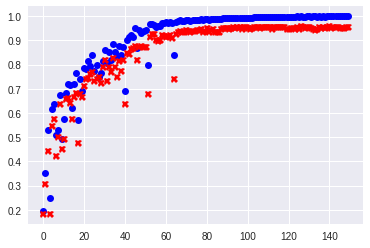

In [11]:
# Notice that accuracy flattens out
print('Train Accuracy: ',np.round(train_acc[-1],2))
print('Test_Accuracy: ',np.round(test_acc[-1],2))

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rX')

## Confusion Matrix

In [12]:
!pip install pandas_ml

    100% |████████████████████████████████| 81kB 1.9MB/s 
  Running setup.py bdist_wheel for pandas-ml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/13/57/a6/6c0dc8cffa09bb45bfb0b4f88fc13871342bac6a6394784f83
Successfully built pandas-ml


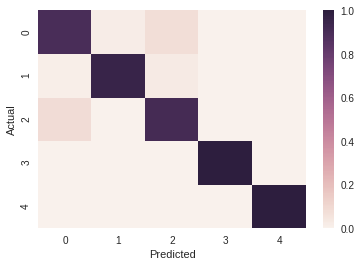

In [13]:
from pandas_ml import ConfusionMatrix

ConfMatrix=ConfusionMatrix(np.argmax(onehot_test,1), np.argmax(cnn_test_pred,1))

ConfMatrix.plot(normalized=True,backend='seaborn')

In [14]:
ConfMatrix.print_stats()

Confusion Matrix:

Predicted   0   1   2   3   4  __all__
Actual                                
0          55   1   5   0   0       61
1           1  68   2   0   0       71
2           4   0  44   0   0       48
3           0   0   0  43   0       43
4           0   0   0   0  56       56
__all__    60  69  51  43  56      279


Overall Statistics:

Accuracy: 0.953405017921147
95% CI: (0.9216390667092866, 0.9749601338596147)
No Information Rate: ToDo
P-Value [Acc > NIR]: 7.610877700067563e-142
Kappa: 0.9413571763488497
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0           1          2  \
Population                                   279         279        279   
P: Condition positive                         61          71         48   
N: Condition negative                        218         208        231   
Test outcome positive                         60          69         51   
Test outcome negative                        219

/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


In [15]:
from sklearn.metrics import confusion_matrix as cm

ConfMatrix=cm(np.argmax(onehot_test,1), np.argmax(cnn_test_pred,1))

print('Confusion Matrix:\n',ConfMatrix)

Confusion Matrix:
 [[55  1  5  0  0]
 [ 1 68  2  0  0]
 [ 4  0 44  0  0]
 [ 0  0  0 43  0]
 [ 0  0  0  0 56]]


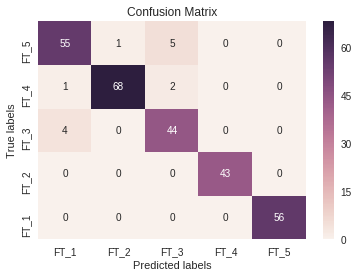

In [16]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(ConfMatrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5'])
ax.yaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5']);